In [14]:
import os
import gzip
import requests
import numpy as np
from tqdm import tqdm

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state

import functools

import matplotlib.pyplot as plt


data_dir = "./data"
device = jax.devices('cpu')[0]

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : TFRT_CPU_0


In [15]:
class MNISTTrainDataset:
    def __init__(self, root="./data"):
        self.save_dir = os.path.join(root, "MNIST", "raw")
        os.makedirs(self.save_dir, exist_ok=True)

        self.files = {
            "train_images": "train-images-idx3-ubyte.gz",
            "train_labels": "train-labels-idx1-ubyte.gz",
        }

        self.paths = {k: os.path.join(self.save_dir, v) for k, v in self.files.items()}

        self.base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
        self._download_if_needed()

        self.x = self._load_images(self.paths["train_images"])
        self.y = self._load_labels(self.paths["train_labels"])

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

    def _download_if_needed(self):
        for key, filename in self.files.items():
            path = self.paths[key]

            if os.path.exists(path):
                continue

            url = self.base_url + filename
            response = requests.get(url, stream=True)

            if response.status_code != 200:
                raise RuntimeError(f"Failed to download {filename}, error: {response.status_code}")

            download_desc = f"Downloading {filename}"
            size = int(response.headers.get('content-length', 0))
            tqdm_bar = tqdm(desc=download_desc, total=size, unit='B', unit_scale=True)
            with open(path, "wb") as f, tqdm_bar:
                for chunk in response.iter_content(chunk_size=1024):
                    f.write(chunk)
                    tqdm_bar.update(len(chunk))

    def _load_images(self, path):
        with gzip.open(path, 'rb') as f:
            f.read(16)
            data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(-1, 28, 28)

    def _load_labels(self, path):
        with gzip.open(path, 'rb') as f:
            f.read(8)
            data = np.frombuffer(f.read(), dtype=np.uint8)
            return data


class BinarizedMNISTDataset:
    def __init__(self, raw_dataset):
        self.x = self._preprocess_x(raw_dataset.x)
        self.y = raw_dataset.y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

    @staticmethod
    def _preprocess_x(x):
        x = x.astype(np.float32) / 255.0            # normalize to [0, 1]
        x = x > 0.5                                 # binarize
        x = x.reshape(x.shape[0], -1)               # flatten
        return jnp.array(x, dtype=jnp.float32)      # use jax numpy array of dtype float32, same as RBM parameters


class DataLoader:
    def __init__(self, dataset, batch_size=128, shuffle=True, drop_last=False):
        self.x = dataset.x
        self.y = dataset.y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.n_samples = self.x.shape[0]

        self.batch_slices = []
        start = 0
        while start < self.n_samples:
            end = start + self.batch_size
            if end > self.n_samples and self.drop_last:
                break
            self.batch_slices.append((start, end))
            start = end

    def __iter__(self):
        indices = np.arange(self.n_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start, end in self.batch_slices:
            excerpt = indices[start:end]
            yield self.x[excerpt], self.y[excerpt]

    def __len__(self):
        return len(self.batch_slices)

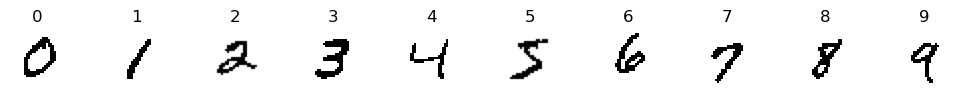

In [16]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# LOAD AND PREPROCESS MNIST DATA
train_raw = MNISTTrainDataset(root=data_dir)
train = BinarizedMNISTDataset(train_raw)

sample_list = [(label, next(image.reshape(28, 28) for image, lbl in train if lbl == label)) for label in range(10)]
print_samples(sample_list)

In [17]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1

    @nn.compact
    def __call__(self, data_batch: jnp.ndarray, v_persistent: jnp.ndarray, rng: PRNGKey) -> (jnp.ndarray, jnp.ndarray):
        # in flax, __call__ is the main computation to be differentiated.

        # initialize parameters in @nn.compact style:
        W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        b = self.param("b", nn.initializers.zeros,        (self.n_visible,))
        c = self.param("c", nn.initializers.zeros,        (self.n_hidden,))
        params = {"W": W, "b": b, "c": c}

        # gibbs sampling only refines the fantasy particles, we are actually not interested in the gradients
        v_k, key = self._gibbs_sample(params, v_persistent, rng, k=self.k)
        v_k = jax.lax.stop_gradient(v_k)

        # we are interested in the gradients of the free energy w.r.t. the parameters
        free_energy_data  = self._free_energy(params, data_batch)
        free_energy_model = self._free_energy(params, v_k)

        pcd_loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)
        # since this is a pcd loss function, we also return the updated fantasy particles. and we also pass through the key
        # since JAX’s tree utilities flatten nested tuples we need to wrap the auxiliary variables in a container
        aux_vars = {"v_persistent": v_k, "key": key}

        return pcd_loss, aux_vars

    @staticmethod
    def _free_energy(params, v):
        W, b, c = params["W"], params["b"], params["c"]

        visible_term = jnp.dot(v, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    @staticmethod
    def _gibbs_step(i, state, params, T=1.0):
        v, key = state
        W, b, c = params["W"], params["b"], params["c"]

        # splitting generates different random numbers for each step, one of them is passed on
        key, h_key, v_key = jax.random.split(key, 3)

        h_logits = (v @ W + c) / T
        h_probs = jax.nn.sigmoid(h_logits)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_logits = (h @ W.T + b) / T
        v_probs = jax.nn.sigmoid(v_logits)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)
        return v, key

    @staticmethod
    def _gibbs_sample(params, v_init, rng, k=1, T=1.0):
        # the fori_loop enables JIT compilation of loops. It basically unrolls the loop over the fixed length k.

        body_fun = lambda i, state: RBM._gibbs_step(i, state, params, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_init, rng))
        return v_final, key

    @staticmethod
    def _annealing_step(i, state, params, T_schedule):
        v, rng = state
        T = T_schedule[i]
        # Perform one Gibbs step using the current temperature T.
        # Note: _gibbs_sample already handles k=1 and T
        v_next, rng_next = RBM._gibbs_sample(params, v, rng, k=1, T=T)
        return (v_next, rng_next)

    # the nowrap attribute basically tells JAX to not do the magic wrapping, which injects the params argument
    @nn.nowrap
    def generate(self, params: dict, n_samples: int, T_schedule: jnp.ndarray, rng: PRNGKey) -> jnp.ndarray:

        # get the initial state and perform initial key splitting
        rng, init_key = jax.random.split(rng)
        v = jax.random.bernoulli(init_key, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)
        init_state = (v, rng)

        body_fun = lambda i, state: RBM._gibbs_step(i, state, params, T_schedule[i])

        # the fori_loop is still required, since this function will also be JIT-compiled
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), body_fun, init_state)
        return v_final

In [18]:
class RBMTrainState(train_state.TrainState):
    """
    A value object bundling parameters and optimizer state for training.
    It has a few pre-defined fields to be used in the training loop.
    Since it is immutable, the training function needs to return a new instance after each update step.
    """
    pass


@functools.partial(jax.jit)
def train_step(state: RBMTrainState, data_batch: jnp.ndarray, v_persistent: jnp.ndarray, key: PRNGKey):

    # only the 'params' argument remains a variable to be differentiated
    pcd_loss_fn = lambda params: state.apply_fn({'params': params}, data_batch, v_persistent, key)

    # since our pc_loss_fn also returns the updated fantasy particles, we need to use has_aux=True
    value_and_grad_fn = jax.value_and_grad(pcd_loss_fn, has_aux=True)
    (pcd_loss, aux_vars), pdc_loss_grads = value_and_grad_fn(state.params)

    # apply the gradients to the state, this actually updates the optimizer state
    new_state = state.apply_gradients(grads=pdc_loss_grads)
    v_persistent = aux_vars["v_persistent"]
    key = aux_vars["key"]

    return new_state, pcd_loss, v_persistent, key


def train_rbm(state: RBMTrainState, train_loader, num_epochs: int, rng: PRNGKey, pcd_reset: int = 5, scheduler=None):
    metrics = {}

    for epoch in range(num_epochs):
        total_loss = 0.0
        batch_count = 0

        for batch_idx, (data, labels) in enumerate(train_loader):

            if batch_idx % pcd_reset == 0:
                rng, subkey = jax.random.split(rng)
                v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=data.shape).astype(jnp.float32)

            state, loss, v_persistent, rng = train_step(state, data, v_persistent, rng)
            total_loss += loss
            batch_count += 1

        avg_loss = total_loss / len(train_loader)
        metrics[epoch] = {"free_energy_loss": float(avg_loss)}
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {avg_loss:.4f}")

    return state, metrics, rng

In [19]:
# ACTUAL TRAINING
batch_size    = 128
visible_units = 28 * 28
hidden_units  = 256
k_steps       = 1
lr            = 1e-3
num_epochs    = 40
pcd_reset     = 75        # reset persistent chain every N batches
weight_decay  = 1e-5      # if needed; see optax.add_decayed_weights
lr_decay      = 0.95      # not used explicitly here


# start of our random key-chain, it will be updated by regular splits (typically at each bernoulli sampling)
rng = PRNGKey(0)

# instantiate the optimizer and the RBM
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
lr_schedule = optax.exponential_decay(init_value=lr, transition_steps=len(train_loader), decay_rate=lr_decay, staircase=True)
optimizer = optax.adam(learning_rate=lr_schedule)
rbm = RBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps)

# initialize RBM parameters and create the training state
dummy_batch = train.x[:batch_size]
rng, subkey = jax.random.split(rng)
v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=dummy_batch.shape).astype(jnp.float32)
params = rbm.init(rng, dummy_batch, v_persistent, rng)['params']
state = RBMTrainState.create(apply_fn=rbm.apply, params=params, tx=optimizer)

state, metrics, rng = train_rbm(state, train_loader, num_epochs, rng, pcd_reset=pcd_reset, scheduler=lr_schedule)

Epoch [1/40] - Free Energy Loss: -80.3972
Epoch [2/40] - Free Energy Loss: -157.9078
Epoch [3/40] - Free Energy Loss: -219.1889
Epoch [4/40] - Free Energy Loss: -200.7801
Epoch [5/40] - Free Energy Loss: -194.8376
Epoch [6/40] - Free Energy Loss: -173.8147
Epoch [7/40] - Free Energy Loss: -117.1137
Epoch [8/40] - Free Energy Loss: -101.4182
Epoch [9/40] - Free Energy Loss: -81.5462
Epoch [10/40] - Free Energy Loss: -72.3013
Epoch [11/40] - Free Energy Loss: -67.0918
Epoch [12/40] - Free Energy Loss: -70.0150
Epoch [13/40] - Free Energy Loss: -65.7026
Epoch [14/40] - Free Energy Loss: -63.1404
Epoch [15/40] - Free Energy Loss: -60.1965
Epoch [16/40] - Free Energy Loss: -57.1857
Epoch [17/40] - Free Energy Loss: -54.3402
Epoch [18/40] - Free Energy Loss: -53.8880
Epoch [19/40] - Free Energy Loss: -51.2630
Epoch [20/40] - Free Energy Loss: -49.4386
Epoch [21/40] - Free Energy Loss: -49.3501
Epoch [22/40] - Free Energy Loss: -49.1426
Epoch [23/40] - Free Energy Loss: -44.5867
Epoch [24/40]

Text(0, 0.5, 'Free Energy Loss')

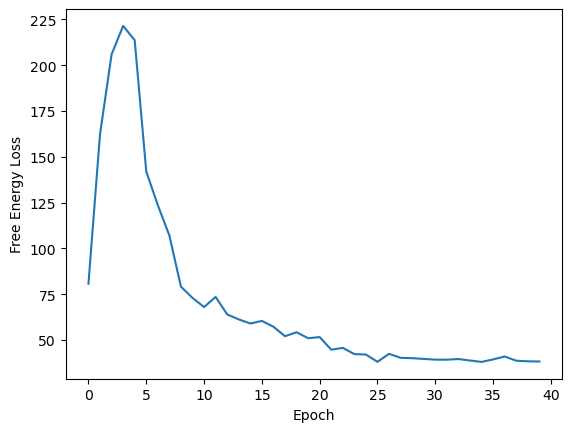

In [12]:
plt.plot([abs(metrics[epoch]['free_energy_loss']) for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

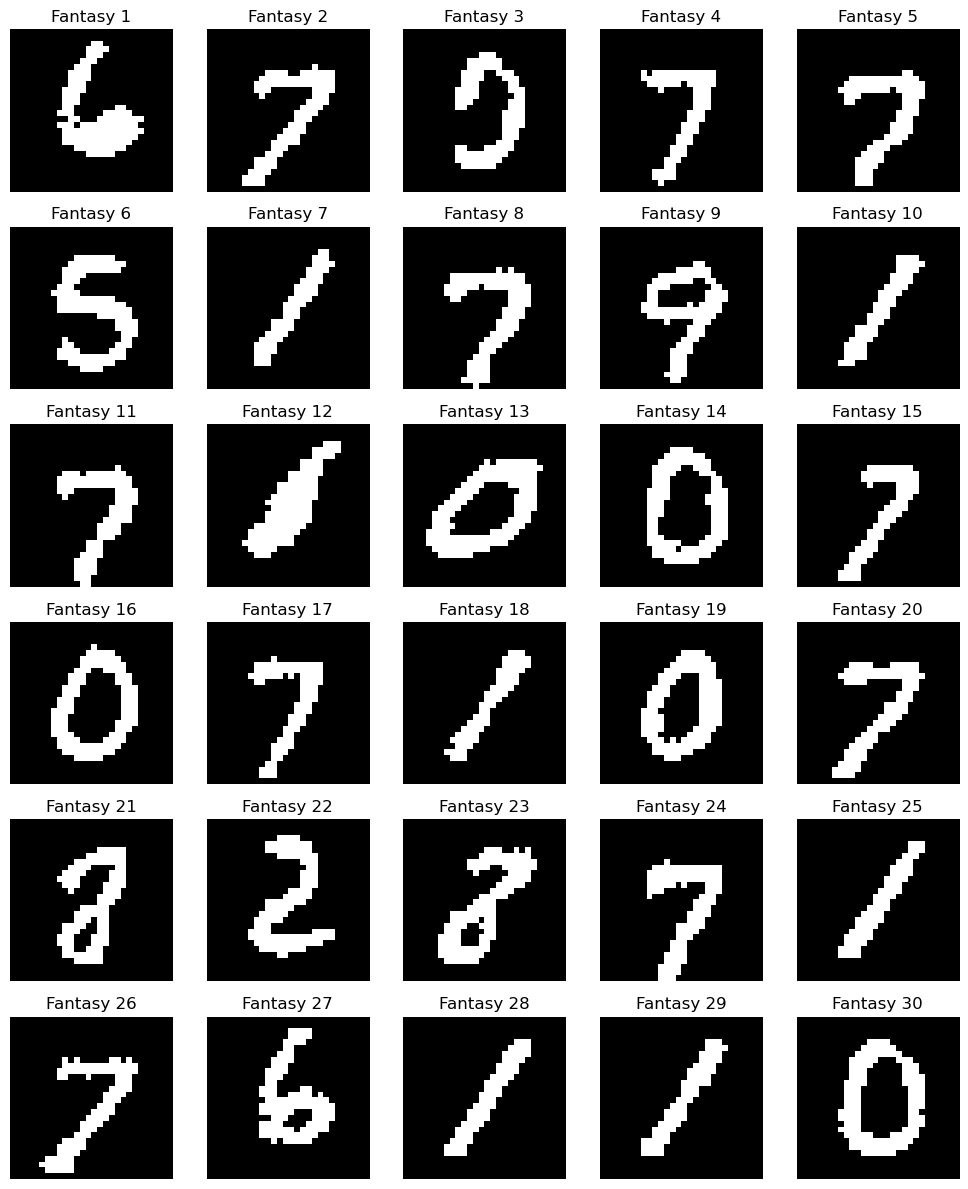

In [13]:
def get_cosine_schedule(T_high, T_low, n_steps):
    steps = jnp.arange(n_steps, dtype=jnp.float32)
    cos = 0.5 * (1 + jnp.cos(jnp.pi * steps / (n_steps - 1)))
    return T_low + (T_high - T_low) * cos


cosine_schedule = get_cosine_schedule(4.0, 0.4, 1000)
samples = rbm.generate(params = state.params, n_samples=30, T_schedule=cosine_schedule, rng=rng).reshape(-1, 1, 28, 28)

labeled_samples = [(f"Fantasy {idx + 1}", img) for idx, img in enumerate(samples)]
print_samples(labeled_samples, elements_per_row=5, fig_width=10, cmap="gray")